In [255]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 

genSavePath = "F:/PythonProjects/NietoExcercise-1/SavedResults/"
day = "09" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 17
repetitionName =   "testingud3isoldBaseline11" # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBestSeed*")

saveTop = True
if saveTop:
    saveTopName = "top1udrlv"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

66
7.333333333333333


In [256]:
import pandas as pd
from array import ArrayType
from requests import delete
from tabulate import tabulate
from prettytable import PrettyTable as pt
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0
nrOfCombination = 0
currSeed = 0
currSubj = 0
combinationList = []
combinationResult = []


results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
for x in range(subjectAmount):
    combinationResult.append([])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
for s, subject in enumerate(results):
    currSubj = 0
    currSeed = 0
    subjectBestArray = np.empty([len(subject)], dtype=object)

    currSeed = subject[0]
    currSubj = subject[1]

    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                if ares > 0.98:
                    ares = 0.99
                akernel = aResults2[2]
                
                
                # if "lin" in akernel:
                #     continue
                # if "sig" in akernel:
                #     continue
                aC = round(aResults2[3], 2)

                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [nameDict[aName], kernelDict[akernel], aC] not in combinationList:
                    combinationList.append([nameDict[aName], kernelDict[akernel], aC])
                    nrOfCombination += 1

                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aC]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                    
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])

                    # If the np array comes from NN results
            else:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                akernel = aResults2[2]
                aLz = round(aResults2[3], 2)
                areg = round(aResults2[4], 2)
                adrp = round(aResults2[5], 2)
                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [
                    nameDict[aName],
                    kernelDict[akernel],
                    aLz,
                    areg,
                    adrp,
                ] not in combinationList:
                    combinationList.append(
                        [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                    )
                    nrOfCombination += 1
                # combResult = []
                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                  
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])


# Making table

# headers = [f"{x[0]}:{x[1]}:{x[2]}:" for x in combinationList]
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
nameArray = np.array(list(nameDict))
topPerFeature = np.zeros([10, len(nameDict)])
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, res[0]] = comboAverage[0, res[0]] + res[1]
            comboTotal[0, res[0]] = comboTotal[0, res[0]] + res[1]
            nrOfSubjects[res[0]] += 1
            subjectResultArray[subNr, res[0]] = res[1]
            
            comboName = list(nameDict.keys())[combinationList[res[0]][0]]
            nameIndex = np.where(nameArray == comboName)[0][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()

            
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
# Print the table!
comboAverage = comboAverage / nrOfSubjects
print(comboAverage.shape)
print(subjectResultArray.shape)
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




(1, 1407)
(10, 1407)


0         1         2         3         4         5         6     \
0      None      None      None      None      None      None      None   
1   0.45625    0.4625    0.3875   0.49375   0.54375   0.51875    0.5125   
2  0.458333  0.489583  0.473958  0.546875  0.473958    0.4375       0.5   
3  0.541667  0.506944  0.486111  0.472222  0.465278  0.493056  0.416667   
4  0.482143  0.494048   0.47619  0.511905  0.458333       0.5  0.422619   
5  0.434524   0.39881  0.422619  0.452381  0.410714  0.369048  0.535714   
6  0.538961  0.532468  0.519481  0.441558  0.480519       0.5  0.409091   
7  0.529762  0.446429  0.446429  0.464286  0.488095  0.494048  0.494048   
8       0.5  0.485714  0.535714  0.557143  0.571429  0.578571  0.521429   
9  0.464286  0.422619  0.410714  0.547619  0.547619  0.589286   0.47619   

       7         8         9         10        11        12        13    \
0      None      None      None      None      None      None      None   
1      0.55    0.6375    0.4625   0.41875    0.5375   0.86875   0.88125   
2  0.484375  0.463542  0.520833    0.5625  0.520833   0.84375  0.838542   
3  0.409722  0.444444       0.5  0.451389  0.402778  0.645833  0.583333   
4  0.369048  0.452381  0.547619  0.553571   0.52381  0.892857  0.845238   
5  0.464286  0.488095  0.446429   0.47619  0.428571  0.922619  0.827381   
6  0.383117  0.402597  0.487013  0.409091  0.558442   0.75974   0.61039   
7  0.547619  0.535714  0.511905  0.470238  0.458333  0.869048  0.863095   
8       0.5  0.457143  0.507143  0.471429  0.471429  0.932857       0.9   
9  0.517857  0.529762  0.511905   0.52381  0.505952  0.797619  0.654762   

       14        15        16        17        18        19        20    \
0      None      None      None      None      None      None      None   
1     0.875   0.86125     0.855   0.87375    0.6125       0.5     0.625   
2   0.84375  0.858125     0.875     0.875  0.541667  0.588542     0.625   
3  0.756944  0.576389  0.541667  0.618056  0.506944  0.520833  0.527778   
4  0.885476  0.815476  0.791667  0.815476  0.845238  0.809524  0.863095   
5  0.880952  0.891429  0.815476  0.942143  0.779762  0.720238  0.791667   
6  0.727273  0.785714  0.545455  0.836234  0.564935       0.5  0.545455   
7  0.869048  0.845238  0.791667  0.839286  0.666667  0.517857  0.589286   
8  0.898571       0.9       0.9       0.9  0.785714  0.757143  0.792857   
9  0.755952  0.833333  0.767857  0.845238  0.440476  0.410714   0.47619   

       21        22        23        24        25        26        27    \
0      None      None      None      None      None      None      None   
1   0.94625   0.95875      0.93    0.9225    0.9225   0.90375    0.8125   
2      0.99  0.986042  0.986042  0.972917  0.972917  0.915417  0.807292   
3  0.947639  0.947639  0.915417  0.914167  0.900278  0.868056  0.847222   
4  0.976429  0.980952  0.976429  0.976429  0.976429  0.965952  0.833333   
5      0.99      0.99  0.976429  0.971905  0.970476  0.965952  0.803571   
6  0.896104  0.883117  0.920649   0.87013  0.857143  0.883117  0.837662   
7  0.961429  0.965952  0.961429  0.961429  0.949524  0.970476  0.869048   
8  0.972857       0.9  0.952857  0.934286  0.892857  0.905714  0.878571   
9      0.96  0.943571  0.976429  0.857143   0.85119  0.892857  0.785714   

       28        29        30        31        32        33        34    \
0      None      None      None      None      None      None      None   
1    0.8375   0.84375    0.4375   0.35625       0.5     0.905    0.8675   
2  0.791667    0.8125  0.453125  0.557292  0.473958  0.862083  0.868542   
3  0.840278  0.798611  0.416667  0.465278    0.4375  0.791667  0.722222   
4  0.821429  0.815476  0.517857       0.5  0.416667  0.863095  0.779762   
5  0.779762     0.875  0.547619  0.482143  0.565476  0.861667  0.833333   
6  0.831169  0.837662  0.519481  0.415584  0.435065  0.727273  0.571429   
7  0.880952  0.892857  0.470238  0.410714  0.440476  0.827381  0.803571   
8       0.9  0.905714  0.492

In [257]:
x = 0

pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
print(nameDictNrs.shape)
#table = pd.DataFrame(nameDictNrs , columns=nameDict.keys())
table = pd.DataFrame(topPerFeature, columns=nameDict.keys())
#display(table)
display(table)
# for names in nameDict.keys():
#     print(names, end="        ")
#     x +=1
#     #print(x)



(1, 469)


,-fftData,-welchData,-dataHR,-dataCorr1d,-dataFFTCV-BC,-dataWCV-BC,-dataHRCV-BC,-fftDataBC,-welchDataBC,-dataHRBC,-gaussianData,-dataGCVBC,-gaussianDataBC,-dataCorr1dBC,welchData--fftData,dataHR--fftData,dataCorr1d--fftData,dataFFTCV-BC--fftData,dataWCV-BC--fftData,dataHRCV-BC--fftData,fftDataBC--fftData,welchDataBC--fftData,dataHRBC--fftData,gaussianData--fftData,dataGCVBC--fftData,gaussianDataBC--fftData,dataCorr1dBC--fftData,dataHR--welchData,dataCorr1d--welchData,dataFFTCV-BC--welchData,dataWCV-BC--welchData,dataHRCV-BC--welchData,fftDataBC--welchData,welchDataBC--welchData,dataHRBC--welchData,gaussianData--welchData,dataGCVBC--welchData,gaussianDataBC--welchData,dataCorr1dBC--welchData,dataCorr1d--dataHR,dataFFTCV-BC--dataHR,dataWCV-BC--dataHR,dataHRCV-BC--dataHR,fftDataBC--dataHR,welchDataBC--dataHR,dataHRBC--dataHR,gaussianData--dataHR,dataGCVBC--dataHR,gaussianDataBC--dataHR,dataCorr1dBC--dataHR,dataFFTCV-BC--dataCorr1d,dataWCV-BC--dataCorr1d,dataHRCV-BC--dataCorr1d,fftDataBC--dataCorr1d,welchDataBC--dataCorr1d,dataHRBC--dataCorr1d,gaussianData--dataCorr1d,dataGCVBC--dataCorr1d,gaussianDataBC--dataCorr1d,dataCorr1dBC--dataCorr1d,dataWCV-BC--dataFFTCV-BC,dataHRCV-BC--dataFFTCV-BC,fftDataBC--dataFFTCV-BC,welchDataBC--dataFFTCV-BC,dataHRBC--dataFFTCV-BC,gaussianData--dataFFTCV-BC,dataGCVBC--dataFFTCV-BC,gaussianDataBC--dataFFTCV-BC,dataCorr1dBC--dataFFTCV-BC,dataHRCV-BC--dataWCV-BC,fftDataBC--dataWCV-BC,welchDataBC--dataWCV-BC,dataHRBC--dataWCV-BC,gaussianData--dataWCV-BC,dataGCVBC--dataWCV-BC,gaussianDataBC--dataWCV-BC,dataCorr1dBC--dataWCV-BC,fftDataBC--dataHRCV-BC,welchDataBC--dataHRCV-BC,dataHRBC--dataHRCV-BC,gaussianData--dataHRCV-BC,dataGCVBC--dataHRCV-BC,gaussianDataBC--dataHRCV-BC,dataCorr1dBC--dataHRCV-BC,welchDataBC--fftDataBC,dataHRBC--fftDataBC,gaussianData--fftDataBC,dataGCVBC--fftDataBC,gaussianDataBC--fftDataBC,dataCorr1dBC--fftDataBC,dataHRBC--welchDataBC,gaussianData--welchDataBC,dataGCVBC--welchDataBC,gaussianDataBC--welchDataBC,dataCorr1dBC--welchDataBC,gaussianData--dataHRBC,dataGCVBC--dataHRBC,gaussianDataBC--dataHRBC,dataCorr1dBC--dataHRBC,dataGCVBC--gaussianData,gaussianDataBC--gaussianData,dataCorr1dBC--gaussianData,gaussianDataBC--dataGCVBC,dataCorr1dBC--dataGCVBC,dataCorr1dBC--gaussianDataBC,dataHR-welchData--fftData,dataCorr1d-welchData--fftData,dataFFTCV-BC-welchData--fftData,dataWCV-BC-welchData--fftData,dataHRCV-BC-welchData--fftData,fftDataBC-welchData--fftData,welchDataBC-welchData--fftData,dataHRBC-welchData--fftData,gaussianData-welchData--fftData,dataGCVBC-welchData--fftData,gaussianDataBC-welchData--fftData,dataCorr1dBC-welchData--fftData,dataCorr1d-dataHR--fftData,dataFFTCV-BC-dataHR--fftData,dataWCV-BC-dataHR--fftData,dataHRCV-BC-dataHR--fftData,fftDataBC-dataHR--fftData,welchDataBC-dataHR--fftData,dataHRBC-dataHR--fftData,gaussianData-dataHR--fftData,dataGCVBC-dataHR--fftData,gaussianDataBC-dataHR--fftData,dataCorr1dBC-dataHR--fftData,dataFFTCV-BC-dataCorr1d--fftData,dataWCV-BC-dataCorr1d--fftData,dataHRCV-BC-dataCorr1d--fftData,fftDataBC-dataCorr1d--fftData,welchDataBC-dataCorr1d--fftData,dataHRBC-dataCorr1d--fftData,gaussianData-dataCorr1d--fftData,dataGCVBC-dataCorr1d--fftData,gaussianDataBC-dataCorr1d--fftData,dataCorr1dBC-dataCorr1d--fftData,dataWCV-BC-dataFFTCV-BC--fftData,dataHRCV-BC-dataFFTCV-BC--fftData,fftDataBC-dataFFTCV-BC--fftData,welchDataBC-dataFFTCV-BC--fftData,dataHRBC-dataFFTCV-BC--fftData,gaussianData-dataFFTCV-BC--fftData,dataGCVBC-dataFFTCV-BC--fftData,gaussianDataBC-dataFFTCV-BC--fftData,dataCorr1dBC-dataFFTCV-BC--fftData,dataHRCV-BC-dataWCV-BC--fftData,fftDataBC-dataWCV-BC--fftData,welchDataBC-dataWCV-BC--fftData,dataHRBC-dataWCV-BC--fftData,gaussianData-dataWCV-BC--fftData,dataGCVBC-dataWCV-BC--fftData,gaussianDataBC-dataWCV-BC--fftData,dataCorr1dBC-dataWCV-BC--fftData,fftDataBC-dataHRCV-BC--fftData,welchDataBC-dataHRCV-BC--fftData,dataHRBC-dataHRCV-BC--fftData,gaussianData-dataHRCV-BC--fftData,dataGCVBC-dataHRCV-BC--fftData,gaussianDataBC-dataHRCV-BC--fftData

<Figure size 2160x720 with 0 Axes>

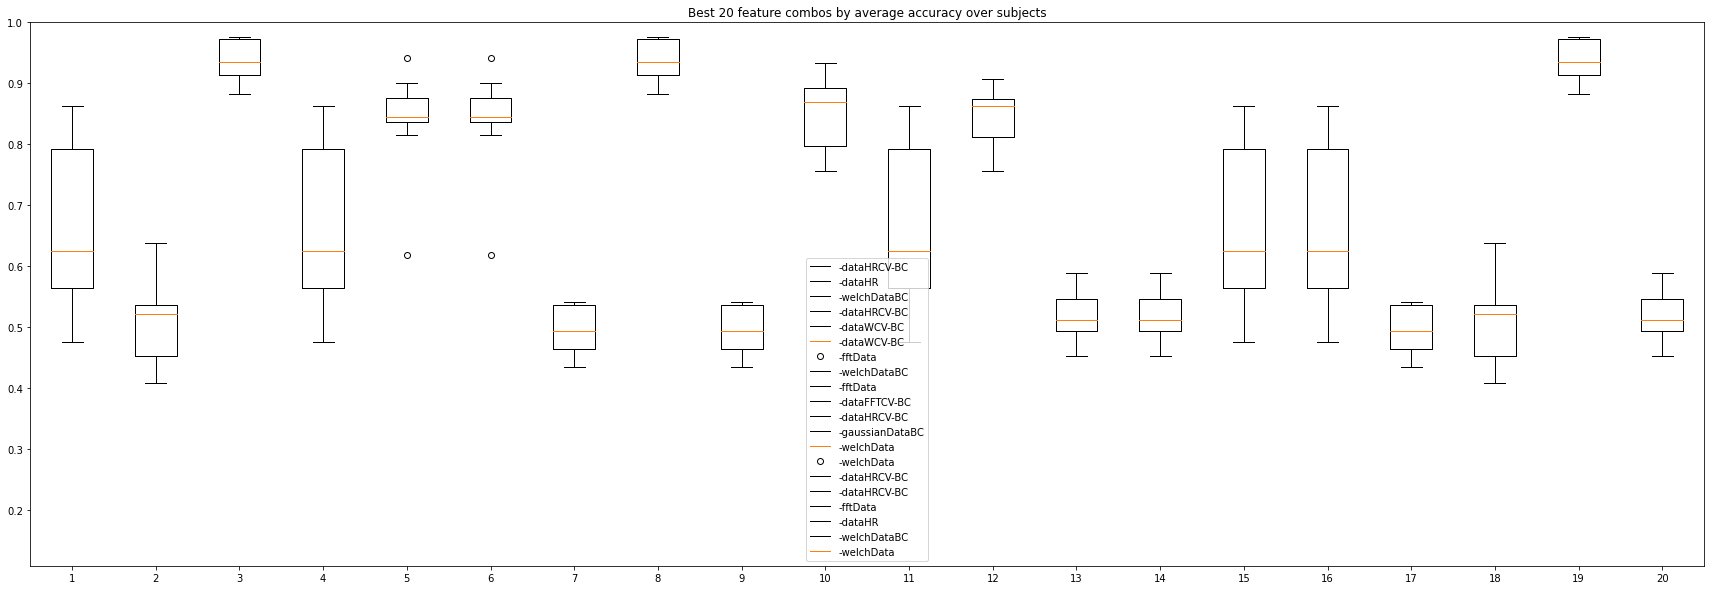

In [258]:
import matplotlib.pyplot as plt
ordeTopAverage = np.array(np.argsort(comboAverage, axis=1)/(len(combinationList))*len(dataF),dtype=int)
#print(ordeTopAverage)

#np.sort(topPerFeature, axis=1)
np.argsort(comboAverage, axis=1)
sortA = np.argsort(topPerFeature, axis = 1)
if len(nameArray) < 25:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature)
    plt.legend(nameArray)
    print("")
else: 
    plt.figure(figsize=[30,10])
    fig, ax = plt.subplots(figsize=[30,10])
    plt.margins(y=1.5)
    ax.set_ylim([np.min(topPerFeature[1:,ordeTopAverage[0][:10]])-0.3,1])
    plt.boxplot(topPerFeature[1:,ordeTopAverage[0][:topAmount]])
    plt.legend(nameArray[ordeTopAverage[0][:topAmount]])
    plt.title(f"Best {topAmount} feature combos by average accuracy over subjects")
    print("")
    


In [259]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.99 : subject 2, feature:welchDataBC--fftDataBC, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:gaussianData--fftDataBC, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:fftDataBC--welchData, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:fftDataBC--fftData, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:fftDataBC--dataWCV-BC, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:fftDataBC--dataHRCV-BC, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:fftDataBC--dataHR, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:fftDataBC--dataFFTCV-BC, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:fftDataBC--dataCorr1d, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:-fftDataBC, kernellinear, C:2.5


In [260]:
# top for each feature

In [261]:
print("Top ten highest accuracies")
#del(topThreeThisSubject[0])
#len(topThreeAllSubjects[0])
for subTop in topThreeAllSubjects:
    subTop.reverse()
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    #subTop.reverse()
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
#print(arrayOfTopFeatureNames)
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
#print(np.array(arrayOfTopFeatureNames, dtype=object).shape)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    temp = topNames.replace("--","-")
    temp2 = temp.replace("-B","%")
    splitArray = np.array(temp2.split("-"),dtype=object)
    for ind, stri in enumerate(splitArray):
        splitArray[ind] = stri.replace("%","-B")
    newArrayOfTopFeatureNames.append(splitArray)
    
  
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    #print(newArrayOfTopFeatureNames)
    np.save(saveTopName, newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")


Top ten highest accuracies

Accuracy 0.99 : subject 5, feature:-fftDataBC, kernelsigmoid, C:2.5

Accuracy 0.99 : subject 4, feature:welchDataBC-fftDataBC--welchData, kernelsigmoid, C:2.5

Accuracy 0.99 : subject 2, feature:fftDataBC--fftData, kernellinear, C:2.5

Accuracy 0.99 : subject 7, feature:dataCorr1dBC-welchDataBC--fftData, kernelsigmoid, C:2.5

Accuracy 0.98 : subject 8, feature:fftDataBC-dataWCV-BC--welchData, kernellinear, C:2.5

Accuracy 0.98 : subject 9, feature:fftDataBC--dataWCV-BC, kernelrbf, C:2.5

Accuracy 0.97 : subject 1, feature:dataGCVBC-welchDataBC--fftDataBC, kernelsigmoid, C:2.5

Accuracy 0.97 : subject 3, feature:gaussianDataBC-welchDataBC--fftDataBC, kernellinear, C:2.5

Accuracy 0.93 : subject 6, feature:fftDataBC--dataFFTCV-BC, kernelrbf, C:2.5
TopFeatureNameArraySaved


In [262]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])
# print(headers[maxInd])
# print(nrOfSubjects[maxInd])
# print(list(nameDict.keys())[combinationList[maxInd][0]])
# print(list(kernelDict.keys())[combinationList[maxInd][1]])
# print(f"C: {combinationList[maxInd][2]}")


[0.         0.83067164 0.80392976 0.75955658 0.86205875 0.84665381
 0.75368648 0.84964768 0.85749619 0.76505432]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

Max average accuracy 0.9608092833092835


In [263]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

dataGCVBC-fftDataBC--dataHRCV-BC
linear
0.9608092833092835

fftDataBC-dataHRCV-BC--dataFFTCV-BC
linear
0.9607702020202021

welchDataBC--fftDataBC
linear
0.9606555635722303

welchDataBC-fftDataBC--dataWCV-BC
linear
0.9606555635722303

dataGCVBC-welchDataBC--fftDataBC
linear
0.9606555635722303



In [264]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

dataGCVBC-fftDataBC--dataHRCV-BC
linear
0.9608092833092835

fftDataBC-dataHRCV-BC--dataFFTCV-BC
linear
0.9607702020202021

welchDataBC--fftDataBC
linear
0.9606555635722303

welchDataBC-fftDataBC--dataWCV-BC
linear
0.9606555635722303

dataGCVBC-welchDataBC--fftDataBC
linear
0.9606555635722303



In [265]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:

    # maxInd2 = int(np.where(comboTotal == maxVal2)[1])
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )

    print(list(nameDict.keys())[combinationList[maxInd2][0]])
    print(list(kernelDict.keys())[combinationList[maxInd2][1]])
    print(f"C: {combinationList[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

1248
9.0
Max total significant accuracy then averaged 0.9608092833092835 
dataGCVBC-fftDataBC--dataHRCV-BC
linear
C: 2.5 


In [266]:
# maxAcc = np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])])
# print(f"Max single accuracy position {np.where(subjectResultArray == maxAcc)}")
# print(np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])]))
